# **Lab 1: Matrix Factorization**
**Mirja Johnsson, building upon the example file provided by Johan Hoffman**

# **Abstract**



```
# This is formatted as code
```



#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [ ]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [2]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common 
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *
    
#import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

 In this lab we are asked to implament some code for working with matrices. 
 Linear algebra is the basis for a lot of what can be done with computers today and therefore it is valuable to learn how to work with them in an efficient way.  

I chose to implement the pseudocode given in the course book (ch. Direct methods for systems of linear equations) for assignments 1.2 and 1.3. 

Here you can express mathematics through Latex syntax, and use hyperlinks for references.

[Hyperlink to DD2363 course website.](https://kth.instructure.com/courses/17068)

$
{\displaystyle \frac{\partial u}{\partial t}} + u\cdot \nabla u +\nabla p = f, \quad \nabla \cdot u=0$



# **Method**

## Assignment 1.1
In assignment 1.1 the task is to write a matrix-vector multiplication function that takes as its input a real quatratic matrix M in compressed-sparse-row format, and a vector x, and returns their product.

For a future implementation I would change this to handle non-square matrices, but didn't do that now.

In [20]:
#Assignment 1.1 
# Input: vector x, sparse (real, quadratic) matrix A: CRS arrays val, col_idx, row_ptr
#Output: matrix-vector product b=Ax
def CSR(row_ptr, col_idx, v, x):
  result = np.zeros(x.size, dtype=float)
  for i in range(row_ptr.size-1):
    r = row_ptr[i+1]-row_ptr[i]
    for j in range(r):
      result[i] += v[j+i]*x[col_idx[j+i]]
  return result    


## Assignment 1.2
I implemented algorithm 5.3 from the course book: Q, R = modified_gram_schmidt_iteration(A):

It is specified that the input matrix A will be square and have full rank, so we do not need to verify this in the function. However for the code to be usable in the future it is a good idea to add these checks. 

For verification I use the frobenius norm from numpy to verify that the solution is close enough to what it should be.



In [21]:
# Assigment 1.2
# QR-factorization

#Input: (real, quadratic, invertible) matrix A
#Output: orthogonal matrix Q, upper triangular matrix R, such that A=QR
#Test: R upper triangular, Frobenius norms || Q^TQ-I ||_F, || QR-A ||_F

#v[:]for the whole column vector v, just write v in python
#and A[:,j] for the jth column vector of the matrix A. 
#Analogously, A[i,:] refers to the ith row vector of A

#(Q, R) = modified_gram_schmidt_iteration(A).
#Input: a full rank n x n matrix A.
#Output: an orthogonal n x n matrix Q and an upper triangular n x n matrix R.
def gram_schmidt_modified(A):
    m,n = A.shape
    if m != n:
        #print("Matrix must be square")
        raise Exception("Matrix must be square")
    if (np.linalg.matrix_rank(A)!= n):
        raise Exception("Matrix must have full rank")   
    Q = np.zeros_like(A, dtype = float)
    R = np.zeros_like(A, dtype = float)
    #n = A.shape[0]
    A = np.copy(A)
    #v = np.zeros(n)
    for j in range(n):
        v = A[:,j]
        for i in range(j):
            R[i,j] = scalar_product(Q[:,i], v)
            v -=  R[i,j]*Q[:,i]
        #end for
        R[j,j] = np.linalg.norm(v)
        Q[:,j] = v/R[j,j]
    #end for
    return Q, R


def scalar_product(v1, v2):
    sum = 0
    if len(v1) != len(v2):
        return None
    else:
      
      for i in range(len(v1)):
          sum += v1[i] * v2[i]
    return sum      

  


Describe the methods you used to solve the problem. This may be a combination of text, mathematical formulas (Latex), algorithms (code), data and output.  

## 1.3
For this part of the assignment we are asked to implement a direct solver for Ax = b, where A is a square matrix and x, b are vectors. A and b are given, and the task is to return x.

Since we have just found a way to factorize a square matrix we can use this to find A^-1 (A inverse) in order to solve for x.
Since A = QR -> Ax = b == QRx = b 


QRx = b    ->    Rx = Q^-1b   ->    x = R^-1 Q^-1 b    -> 


x = R^-1 Q^-1 b

The inverse of an upper triangular matrix like R can be found by using backward substitution. The inverse of an orthogonal matrix like Q is just its transpose.

In [24]:
#1.3

#ALGORITHM 5.2 from the course book  
# Input: an upper triangular matrix U and a vector b. Output: the solution x to the equation Ux = b.
def backward_substitution(U, b):
    x = np.zeros_like(b)
    n = len(x)
    x[n-1] = b[n-1]/U[n-1,n-1]
    for i in range(n-2,-1, -1):
        sum = 0
        for j in range(i+1, n):
            sum = sum + U[i,j]*x[j]
        #end for
        x[i] = (b[i] - sum)/U[i,i]
    #end for
    return x

def direct_solver(A, b):
    Q, R = gram_schmidt_modified(A)    
    Qinv = np.transpose(Q)
    #first multiply b with Q^T since the order of multiplication is non-commutative (generally)
    Qinv_b = np.matmul(Qinv, b)
    #solve for x via backward substitution
    x = backward_substitution(R, Qinv_b)
    return x

# **Results**

Present the results. If the result is an algorithm that you have described under the *Methods* section, you can present the data from verification and performance tests in this section. If the result is the output from a computational experiment this is where you present a selection of that data. 

# TESTS: 
####1.1

I have constructed a 4x4 matrix in both sparse and full representation. We can see that the result of performing the multiplication with vecotr x gives equivalent results when using my CSR function and when using numpy.dot()

In [19]:
rowp = np.array([0,1,2,3,5])
col = np.array([0,1,2,1,3])
v = np.array([4,7,13,6,1], dtype = float)
x = np.array([1,2,2,1], dtype = float)
print("The result of the multiplication using CSR: \n", CSR(rowp,col,v,x), "\n")  
fullmatrix = np.array([[4,0,0,0],[0,7,0,0],[0,0,13,0],[0,6,0,1]])
print("\n The result of using numpy's matrix multiplication with the spare matrix \n", fullmatrix.dot(x), "\n") 

The result of the multiplication using CSR: 
 [ 4. 14. 26. 13.] 


 The result of using numpy's matrix multiplication with the spare matrix 
 [ 4. 14. 26. 13.] 



#### 1.2
To see that R is upper triangular it is enough to run the gram_schmidt algorithm print R, and look at the results. 
To check the frobenius norms I use numpy's norm library and specify that the Frobenius norm should be used. It's actually the default norms for matrices but it doesn't hurt to be clear.



In [5]:
#1.2

if __name__ == "__main__":

    A = np.array(([2,-1,1,0],[0,2,1,0], [0,1,3,0], [0,0,0,5]), dtype = float)
    #A = np.array(([0,0,0,0],[0,2,1,0], [0,1,3,0], [0,0,1,5]), dtype = float)
    Q, R = gram_schmidt_modified(A)
    print("Q: \n", Q, "\n")
    print("R: \n", R, "\n")
  
    #Check QR - A is  0
    print("[QR] - [A] should be  0")
    print(np.linalg.norm(np.matmul(Q,R)-A , ord = 'fro'), "\n")
    #Check Q Q^T -I 
    print("[QQ^T]-I should be very close to 0")
    print(np.linalg.norm(np.matmul(Q,Q.transpose())-np.identity(4), ord = 'fro'))

Q: 
 [[ 1.          0.          0.          0.        ]
 [ 0.          0.89442719 -0.4472136   0.        ]
 [ 0.          0.4472136   0.89442719  0.        ]
 [ 0.          0.          0.          1.        ]] 

R: 
 [[ 2.         -1.          1.          0.        ]
 [ 0.          2.23606798  2.23606798  0.        ]
 [ 0.          0.          2.23606798  0.        ]
 [ 0.          0.          0.          5.        ]] 

[QR] - [A] should be  0
0.0 

[QQ^T]-I should be very close to 0
1.5801635193621484e-16


In [12]:
#1.3
if __name__ == "__main__":

    A = np.array(([2,-1,1,0],[0,2,1,0], [0,1,3,0], [0,0,0,5]), dtype = float)
    b = np.array([0.4,2.0,2.0,3.0], dtype = float)
    x = direct_solver(A, b)
    print("A =  \n", A, "\n")
    print("b = ", b, "\n")
    print("Solved for x: \n")
    print("x = ", x, "\n")
    

    #return
    b_test = np.dot(A,x)
    print("Test to see that we get the original vector b if we multiply A with x \n")
    print("Test : calculated b: ", b_test, " == original b: ", b)
  

A =  
 [[ 2. -1.  1.  0.]
 [ 0.  2.  1.  0.]
 [ 0.  1.  3.  0.]
 [ 0.  0.  0.  5.]] 

b =  [0.4 2.  2.  3. ] 

Solved for x: 

x =  [0.4 0.8 0.4 0.6] 

Test to see that we get the original vector b if we multiply A with x 

Test : calculated b:  [0.4 2.  2.  3. ]  == original b:  [0.4 2.  2.  3. ]


# **Discussion**

Some useful code for linear-algebra applications was implemented in this lab. The code that does this is already available in numpy and scipy and other scientific libraries. However I think it is very valuable for us students to implement them ourselves to get a deeper understanding of what is atually happening. 

# **APPENDIX**

In this appendix some examples are given to express and visualizing mathematical concepts such as vectors, matrices, meshes and functions. 

This is not part of the template report for the course.

# **Vector**

In this cell some basic commands are introduced for how to define and process a vector, where the NumPy array data type is used. 

x = [1 2 3 4]
x[2] = 3
x[0:2] = [1 2]
x.shape = (4,)
x.ndim = 1
x.size = 4
x.dtype = int64
x[ 0 ] = 1
x[ 1 ] = 2
x[ 2 ] = 3
x[ 3 ] = 4
x = [1 2 3 4]
xf = [1.  2.1 3.  4. ]
xf.dtype = float64
y = [2.+0.j 3.+0.j 4.+0.j]
y.dtype = complex128
z = [12.  16.5 21.  25.5]
z = [0.         1.57079633 3.14159265 4.71238898 6.28318531]


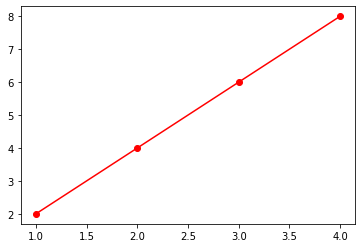

In [ ]:
# Just a test
# Create a vector as a NumPy array
x = np.array([1,2,3,4])

# Print various attributes of the vector
print('x =',x)
print('x[2] =',x[2])
print('x[0:2] =',x[0:2])
print('x.shape =',x.shape)
print('x.ndim =',x.ndim)
print('x.size =',x.size)
print('x.dtype =',x.dtype)

# Print the elements of vector x
for i in range(x.size):
  print("x[",i,"] =",x[i])

# Assign a float value to the int vector x
x[1] = 2.1
print('x =',x)

# Copy the int vector x to a float vector xf
xf = x.astype(float)
xf[1] = 2.1
print('xf =',xf)
print('xf.dtype =',xf.dtype)

# Create a complex vector 
y = np.array([2,3,4], dtype=complex)
print('y =',y)
print('y.dtype =',y.dtype)

# Create a vector z by defining a range through an increment
z = np.arange(12, 28, 4.5)
print('z =',z)

# Overwrite the vector z by a vector of uniformly spaced elements in a range
pi=np.pi
pi
z = np.linspace(0, 2*pi, 5)
print('z =',z)

# Visualize the vector in a plot. 
plt.figure()
plt.plot(x,2*x,'ro-')
plt.show()

# **Matrix**

In this cell some basic commands for defining and processing a matrix
is introduced, where we use the NumPy array data type. 

A = [[2 4 6]
 [3 6 9]
 [1 2 1]]
A[1,0] = 3
A.shape = (3, 3)
A.ndim = 2
A.size = 9
Sparse matrix values: 
 [3 2 2 2 1 1 3 2 1 2 3]
Sparse matrix column indices: 
 [1 2 4 2 3 3 3 4 5 5 6]
Sparse matrix row pointer: 
 [ 1  4  6  7  9 10]


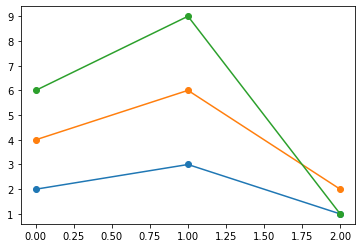

In [ ]:
# Define a matrix as a NumPy array
A = np.array([[2,4,6], [3,6,9], [1,2,1]])

# Print various attributes of the matrix 
print('A =',A)
print('A[1,0] =',A[1,0])
print('A.shape =',A.shape)
print('A.ndim =',A.ndim)
print('A.size =',A.size)

# Plot the matrix
plt.figure()
plt.plot(A,'o-')

# Construct a simple sparse matrix class using the CRS data structure
class spMatrix:
  def __init__(self, val, col_idx, row_ptr):
    self.val = val
    self.col_idx = col_idx
    self.row_ptr = row_ptr
    
# Create a sparse matrix object 
val = np.array([3, 2, 2, 2, 1, 1, 3, 2, 1, 2, 3])
col_idx = np.array([1, 2, 4, 2, 3, 3, 3, 4, 5, 5, 6])
row_ptr = np.array([1, 4, 6, 7, 9, 10])
spA = spMatrix(val, col_idx, row_ptr)

# Print sparse matrix object attributes
print('Sparse matrix values: \n',spA.val)
print('Sparse matrix column indices: \n',spA.col_idx)
print('Sparse matrix row pointer: \n',spA.row_ptr)
    

# **Function**

In this cell we illustrate how functions are defined. 

f(3,4) = 7
z = 13
z = 17
z = 14
A = [[1 2 3]
 [4 5 6]
 [7 8 9]]
A =
1  2  3  
4  5  6  
7  8  9  
A^T =
1  4  7  
2  5  8  
3  6  9  


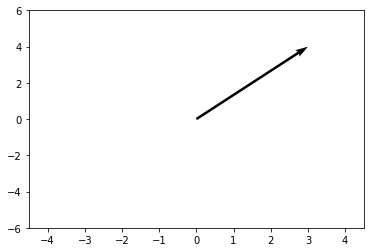

In [ ]:
# Define a function f(x,y)
def f(x,y):
  return x + y 

# Verify the function output
print('f(3,4) =',f(3,4))

# Define a function of a function
def g1(fcn,arg1,arg2):
  z = fcn(arg1,arg2)
  print('z =',z)

# Call the function
g1(f,6,7)

# Define a function of a function with arguments in a list or array
def g2(fcn,arg):
  z = fcn(*arg)
  print('z =',z)
  
# Call the function with arguments as list and array
xlist = [8,9]
xarray = np.array([11,3])
g2(f,xlist)
g2(f,xarray)

# Define a function to format the print out for a matrix 
def printMatrix(A):
   rows = A.shape[0]
   cols = A.shape[1]
   for i in range(0,rows):
      for j in range(0,cols):
         print(A[i,j]," ", end='')
      print()

# Define matrix      
A = np.array([[1,2,3], [4,5,6], [7,8,9]])

# Verify the function output
print('A =', A)
print('A =')
printMatrix(A)
print('A^T =')
printMatrix(A.transpose())

# Plot a Euclidian position vector v 
def plotEVector(vec):
  plt.figure()
  plt.xlim([-1.5*vec[0], 1.5*vec[0]])
  plt.ylim([-1.5*vec[1], 1.5*vec[1]])
  plt.quiver(0, 0, vec[0], vec[1], scale=1, scale_units='xy', angles='xy')
  plt.show()

v = np.array([3,4])
plotEVector(v)




# **Plot**

<Figure size 432x288 with 0 Axes>

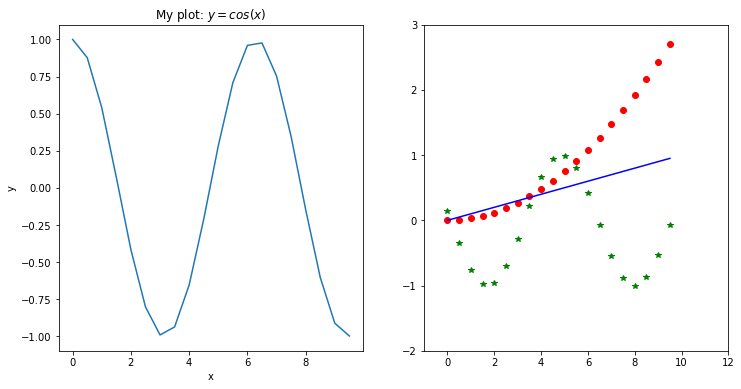

In [ ]:
# Define a range for a parameter t
t = np.arange( 0.0, 10, 0.5)

# Initialize a new figure and set the size 
plt.figure(2)
plt.figure(figsize=(12,6))

# Define a subplot structure and choose the first subplot 
plt.subplot(121)

# Plot a standard NumPy function against the parameter t
plt.plot(t,np.cos(t))

# Set plot labels and title for the subplot
plt.xlabel('x')
plt.ylabel('y')
plt.title('My plot: $y = cos(x)$')

# Choose the other subplot
plt.subplot(122)

# Plot three functions in the same subplot
plt.plot(t, np.sin(f(t,3)), 'g*', t, 0.03*t**2, 'ro', t, 0.1*t, 'b')
plt.axis([-1, 12, -2 ,3])

# Show the figure
plt.show()

# Triangular **mesh**

This cell describes how to generate a triangular mesh from a point cloud by the Delaunay algorithm. It also illustrates how to access the mesh data structures. 

Mesh generation took:  0.005940675735473633 seconds (wall-clock time)
vertices = 
 [[0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75
  1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.  ]
 [0.   0.   0.   0.   0.   0.25 0.25 0.25 0.25 0.25 0.5  0.5  0.5  0.5
  0.5  0.75 0.75 0.75 0.75 0.75 1.   1.   1.   1.   1.  ]]
edges = 
 [[ 1  0]
 [ 2  1]
 [ 3  2]
 [ 4  3]
 [ 5  0]
 [ 5  1]
 [ 6  1]
 [ 6  5]
 [ 7  1]
 [ 7  2]
 [ 7  3]
 [ 7  6]
 [ 8  3]
 [ 8  7]
 [ 9  3]
 [ 9  4]
 [ 9  8]
 [10  5]
 [11  5]
 [11  6]
 [11  7]
 [11 10]
 [12  7]
 [12 11]
 [13  7]
 [13  8]
 [13  9]
 [13 12]
 [14  9]
 [14 13]
 [15 10]
 [15 11]
 [16 11]
 [16 15]
 [17 11]
 [17 12]
 [17 13]
 [17 16]
 [18 13]
 [18 17]
 [19 13]
 [19 14]
 [19 18]
 [20 15]
 [21 15]
 [21 16]
 [21 17]
 [21 20]
 [22 17]
 [22 21]
 [23 17]
 [23 18]
 [23 19]
 [23 22]
 [24 19]
 [24 23]]
triangles = 
 [[ 0  1  5]
 [ 5  1  6]
 [ 9  3  4]
 [ 8  3  9]
 [ 6  1  7]
 [ 7  1  2]
 [ 7  3  8]
 [ 2  3  7]
 [20 15 21]
 [21 15 16]
 [ 6  7 

<Figure size 432x288 with 0 Axes>

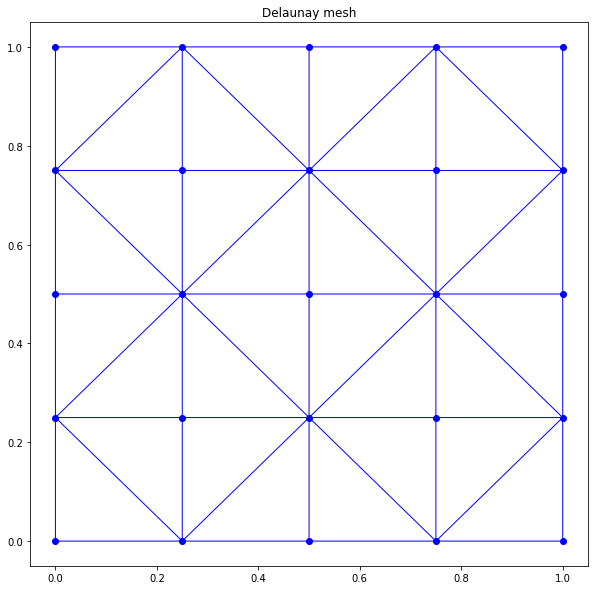

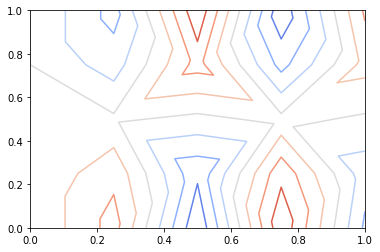

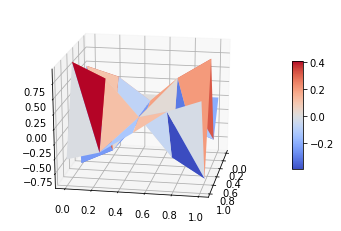

In [ ]:
# Start the clock 
start = time.time()

# Generate a point cloud
Nx = 5
Ny = 5
hx = 1.0/(Nx-1)
hy = 1.0/(Ny-1)
x = np.zeros((Nx*Ny))
y = np.zeros((Nx*Ny))
for i in range(Nx):
  for j in range(Ny):
    x[i*Nx + j] = j*hx
    y[i*Nx + j] = i*hy

# Generate a mesh from the point cloud using a Delaunay algorithm
mesh = tri.Triangulation( x, y )

# Stop the clock
end = time.time()

# Print the measured time
print ("Mesh generation took: ", end - start, "seconds (wall-clock time)")

# Print mesh data structure
vertices = np.array([mesh.x, mesh.y])
print('vertices = \n', vertices)
print('edges = \n', mesh.edges)
print('triangles = \n', mesh.triangles)
print('neighbor triangles = \n', mesh.neighbors)

# Plot the mesh 
plt.figure(3)
plt.figure(figsize=(10,10))
plt.triplot(mesh, 'bo-', lw=1)
plt.title('Delaunay mesh')
plt.show()

# Define a function g(x,y)
def g(x,y):
    return np.sin(10*x)*np.cos(3*y)

# Plot the function g(x,y) in a contour plot
plt.figure(4)
plt.tricontour(mesh, g(x,y), cmap=plt.cm.coolwarm)
plt.show()

# Plot the function g(x,y) in 3D as a surface plot
fig = plt.figure(5)
ax1 = fig.add_subplot(111, projection='3d')
surf = ax1.plot_trisurf(mesh, g(x,y), cmap=plt.cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax1.view_init(20,10)
plt.show()

# Parametric **curve**

This cell illustrates how to visualize a parametric curve.

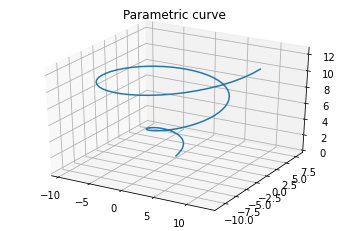

In [ ]:
# Define paramter range
t = np.linspace(0, 4*np.pi, 100)

# Define the curve
x = t*np.cos(t)
y = t*np.sin(t)
z = t

fig = plt.figure(6)
ax = fig.gca(projection = '3d')
ax.plot(x, y, z)
plt.title('Parametric curve')
plt.show()